## 敏感度
GS(f) = max|f(x)-f‘(x)|
其中d(x,x`)表示两个数据集x和x1之间的距离（Distance）。如果两个数据集之间的距离小于等于1，我们称这两个数据集是临近集（Neighbor）。数据集的距离定义会对隐私定义带来很大的影响。我们稍后将讨论如何度量数据集之间的距离。

#### 距离
通常会把距离定义为有多少行数据值不相同。
添加或删除一行数据可以生成相邻数据集；修改一行数据则生成距离为2的数据集。

#### 计算敏感度
f(x) = x的全局敏感度是1，因为x变化1，f(x)变化为1
f(x) = x + x的全局敏感度是2，因为x变化1，f(x)变化为2
f(x) = 5 * x的全局敏感度是5，因为x变化1，f(x)变化为5
f(x) = x * x的全局敏感度是无界的，因为f(x)的变化取决于x的值

对于将数据集映射到实数的函数，我们都采用类似的分析方法。我们下面将考虑3个常见的数据库聚合问询函数:计数问询、求和问询、均值问询。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')

adult = pd.read_csv("adult_with_pii.csv")

### 计数问询
计数问询（数据库SQL中的COUNT算子）计算数据集中满足特定属性的行数。一般来说，计数问询的敏感度总等于1。这是因为向数据集中添加一行数据最多会使问询的输出结果增加1，即当新增行满足特定属性时，计数结果加1。反之，当新增行不满足特定属性时，计数结果不变（删除行可能使计数结果减1）。

例子：”数据集中有多少人？”（敏感度：1，计算总行数）

In [2]:
adult.shape[0]

32563

例子：”受教育年数超过10年的有多少人”（敏感度：1，根据属性计算行数）

In [3]:
adult[adult['Education-Num'] > 10].shape[0]

10517

例子：”受教育年数小于或等于10年的有多少人？”（敏感度：1，根据属性计算行数）

In [4]:
adult[adult['Education-Num'] <= 10].shape[0]

22046

例子：”名字叫Joe Near的有多少人？”（敏感度：1，根据属性计算行数）

In [5]:
adult[adult['Name'] == 'Joe Near'].shape[0]

0

### 求和问询

求和问询（数据库SQL中的SUM算子）计算数据集行中的属性值（Attribute Values） 总和。
**我们需要确定在数据集中对单个个体数据进行更改时，求和函数 ( f ) 输出结果的最大变化量。对于求和查询来说，当我们向数据集中添加或移除一个数据点时，输出结果的最大变化量就是单个数据点的数值大小。简单来说，求和查询的敏感度就是数据集中单个数据点的数值大小。**

tip:一般来说，当待求和的属性值不存在上界和下界时，我们称求和问询具有无界敏感度。当存在上下界时，求和问询的敏感度等于上下界的差。在下一节，我们将介绍裁剪（Clipping）技术。此技术用于在边界不存在时强制划定边界，以便将无界敏感度的求和问询转化为有界敏感度的问询。

例子：”受教育年数超过10年的人，其年龄总和是多少？”

In [6]:
adult[adult['Education-Num'] > 10]['Age'].sum()

441431

### 均值问询

均值问询（数据库SQL中的AVG算子）计算指定列属性值的平均值。
**简单来说，均值查询的敏感度是单个数据点的数值除以数据集大小。这意味着敏感度受数据集中数据点数量的影响，因为在计算均值时，数据集中数据点数量的变化会影响输出结果的变化程度**

例子：”受教育年数超过10年的人，其平均年龄是多少？”

In [7]:
adult[adult['Education-Num'] > 10]['Age'].mean()

41.973091185699346

#### 求和问询和计数问询的敏感度都可以根据前面提到的方法计算得到。因此，我们可以分别计算两个问询的噪声回复（如使用拉普拉斯机制）。对两个噪声回复做除法，即可得到差分隐私均值。我们可以应用串行组合性计算两个问询的总隐私消耗量。

### 裁剪

差分隐私的拉普拉斯机制的无法直接应用于无界敏感度问询。幸运的是，我们通常可以利用裁剪（Clip）技术将此类问询转换为等价的有界敏感度问询。

裁剪技术的基本思想是，强制设置属性值的上界和下界。例如，125岁以上的年龄可以被”裁剪”到恰好125岁。经过裁剪后，所有年龄都肯定不超过125岁。因此，对裁剪数据执行求和问询的敏感度等于上下界的差：
上界下界。例如，以下问询的敏感度为125：

此外，还需在裁剪造成的信息量损失和满足差分隐私所需的噪声间进行权衡。裁剪边界的上界和下界越接近，敏感度越低，差分隐私所需的噪声就越小。然而，过分裁剪经常会从数据中移除很多信息。这些信息的移除可能给准确度带来损失，超过更小敏感度改善噪声带来的准确度提升效果。

一般来说，要将裁剪边界设置为（尽可能）100%的保留数据集的所有信息。但必须承认，某些领域（例如后续将学习的图问询）很难做到这一点。

In [8]:
adult['Age'].clip(lower=0, upper=125).sum()

1360238

Text(0, 0.5, 'y')

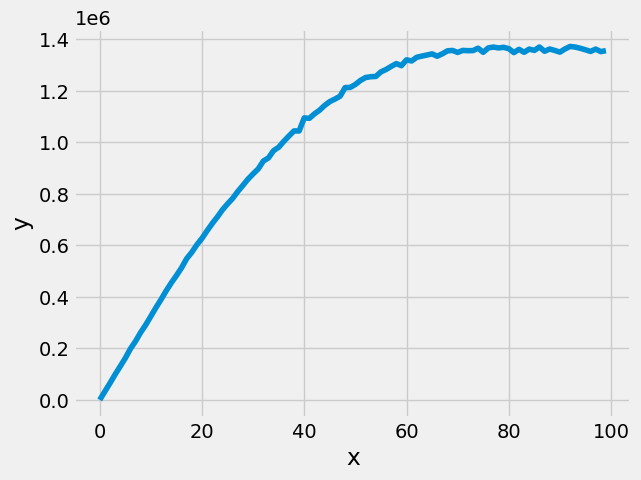

In [9]:
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity/epsilon)

epsilon_i = .01
plt.plot([laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in range(100)])
plt.xlabel('x')
plt.ylabel('y')

我们进行了100次ε=0.01的问询。因此，根据串行组合性，构建上图的总隐私消耗量为ε=1。显然，问询结果在upper = 80附近趋于平稳，把80作为裁剪边界是个不错的选择。

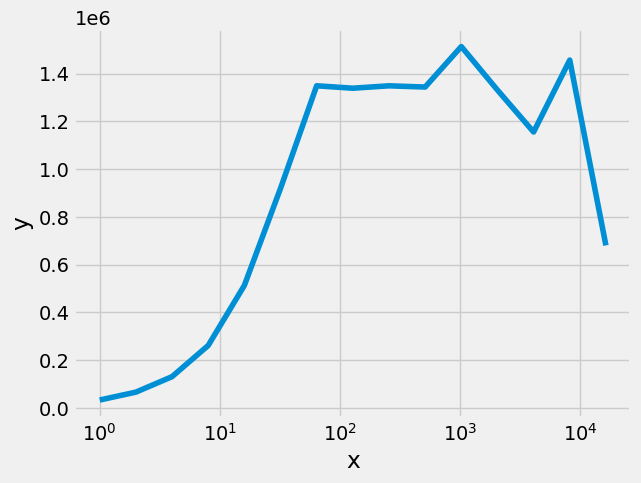

In [10]:
xs = [2**i for i in range(15)]
plt.plot(xs, [laplace_mech(adult['Age'].clip(lower=0, upper=i).sum(), i, epsilon_i) for i in xs])
plt.xscale('log')
plt.xlabel('x')
plt.ylabel('y');